PyQt4/PyQt5 are not available... try running "pip3 install PyQt5"
*** klampt.vis: using GLUT as the visualization backend ***
***      Some functionality may not be available!       ***
klampt.visualization: QT is not available, falling back to poorer
GLUT interface.  Returning to another GLUT thread will not work
properly.



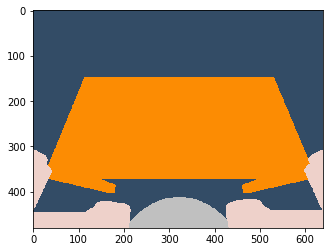

In [1]:
from klampt import WorldModel,Geometry3D
from klampt.model import sensing, ik
import time
import matplotlib.pyplot as plt
import klampt
from klampt import vis
from klampt.math import so3,se3, vectorops
import trimesh
import os
import random
import numpy as np
import math
from math import radians
from IPython.display import clear_output
import ipywidgets as widgets
from klampt.vis.ipython import KlamptWidget

model_path = "../Resources/shared_data/objects/"
mesh_model_path = "../Resources/grasping/models/"

class testingWorldBuilder():
    def __init__(self,floor_length = 20, floor_width = 20):
        self.w = WorldModel()
        self.floor =  Geometry3D()
        self.floor.loadFile(model_path+"cube.off")
        self.floor.transform([floor_length,0,0,0,floor_width,0,0,0,0.01],[-floor_length/2.0,-floor_width/2.0,-0.01])
        floor_terrain = self.w.makeTerrain("floor")
        floor_terrain.geometry().set(self.floor)
        floor_terrain.appearance().setColor(0.4,0.3,0.2,1.0)

        ###colors
        self.light_blue = [3.0/255.0, 140.0/255.0, 252.0/255.0,1.0]
        self.wall_green = [50.0/255.0, 168.0/255.0, 143.0/255.0,1.0]
        ###sizes
        self.table_length = 1.0
        self.table_width = 0.5
        self.table_top_thickness = 0.03
        self.table_height = 0.6
        self.leg_width = 0.05
        self.cube_width = 0.05

    def getWorld(self):
        return self.w

    def addTableTopScenario(self,x=0,y=0):
        """
        add a table with objects on top, the center of table can be set
        Parameters:
        --------------
        x,y: floats, the position of the table center
        """

        self.addTable(x,y)
        # add some cubes
        '''
        self.addCube((so3.from_axis_angle(([0,0,1],0.5)),[x/2,y/2,self.table_height]), self.cube_width, [1.0,0,0,1],1)
        # add one mesh
        self.addRandomMesh([0+x,0.2+y,self.table_height],1)
        self.addRandomMesh([0+x,-0.2+y,self.table_height],2)
        self.addRandomMesh([0.2+x,0+y,self.table_height],3)
        self.addRandomMesh([-0.2+x,-0.2+y,self.table_height],4)
        '''

    ##Functions below add individual objects
    def addCube(self,T,side_length,color,ID,object_mass = 0.1):
        """
        Add a cube to the world.
        Parameters:
        --------------
        T:world transform of the cube
        side_length: float, size of the cube
        color: RGBA values, (0-1)
        ID: int, cannot duplicate
        mass:object mass added at the object geometric center
        """

        self._addRigidObject(model_path + "cube.off",([side_length,0,0,0,side_length,0,0,0,side_length,],[0,0,0]),T,\
            color,object_mass,[side_length/2.0,side_length/2.0,side_length/2.0],"cube"+str(ID))

    def addMesh(self,path,T,color,mass,ID):
        """
        Add a mesh to the world.
        Parameters:
        --------------
        path: path to the mesh file
        T:world transform of the mesh
        color: RGBA values, (0-1)
        mass:object mass added at the object geometric center
        ID: int, cannot duplicate
        """
        mesh = trimesh.load(path)
        mesh_center = mesh.centroid.tolist()

        # load the rigid object in the world
        self._addRigidObject(path,([1,0,0,0,1,0,0,0,1],[0]*3),T,\
            color,mass,mesh_center,"item"+str(ID))

    def addRandomMesh(self,t,ID = 1):
        """
        Add a household item to the world, randonmly selected from the library.
        Color is also determined randomly. Mass set to 1kg arbitrarily
        Parameters:
        --------------
        t:world position of the mesh
        ID: int, cannot duplicate
        """
        meshpaths = []
        for file in os.listdir(mesh_model_path):
            if file.endswith(".ply"):
                meshpaths.append(os.path.join(mesh_model_path, file))

        meshpath = random.choice(meshpaths)
        mesh = trimesh.load(meshpath)
        mesh_center = mesh.centroid.tolist()
        #Z_min = np.min(mesh.vertices[:,2])

        #t[2] = t[2]+mesh_center[2]-Z_min
        # load the rigid object in the world
        self._addRigidObject(meshpath,([1,0,0,0,1,0,0,0,1],[0]*3),([1,0,0,0,1,0,0,0,1],t),\
            (random.random(),random.random(),random.random(),1.0),0.1,mesh_center,"item"+str(ID))

    def addTable(self,x=0,y=0):
        """
        Add a table to the world
        Parameters:
        --------------
        x,y: floats, the x,y position of the center of the table
        """
        table_top = Geometry3D()
        table_leg_1 = Geometry3D()
        table_leg_2 = Geometry3D()
        table_leg_3 = Geometry3D()
        table_leg_4 = Geometry3D()

        table_top.loadFile(model_path + "cube.off")
        table_leg_1.loadFile(model_path + "cube.off")
        table_leg_2.loadFile(model_path + "cube.off")
        table_leg_3.loadFile(model_path + "cube.off")
        table_leg_4.loadFile(model_path + "cube.off")

        table_top.transform([self.table_length,0,0,0,self.table_width,0,0,0,\
            self.table_top_thickness],[0,0,self.table_height - self.table_top_thickness])
        table_leg_1.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height\
            - self.table_top_thickness],[0,0,0])
        table_leg_2.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - \
            self.table_top_thickness],[self.table_length-self.leg_width,0,0])
        table_leg_3.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[self.table_length-self.leg_width,self.table_width-self.leg_width,0])
        table_leg_4.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[0,self.table_width-self.leg_width,0])

        table_geom = Geometry3D()
        table_geom.setGroup()
        for i,elem in enumerate([table_top,table_leg_1,table_leg_2,table_leg_3,table_leg_4]):
            g = Geometry3D(elem)
            table_geom.setElement(i,g)
        #table_geom.transform([1,0,0,0,1,0,0,0,1],[x-self.table_length/2.0,y-self.table_width/2.0,0])
        table_geom.transform(so3.from_rpy([0, 0, math.pi/2]),[x-self.table_length/2.0,y-self.table_width/2.0,0])
        table = self.w.makeTerrain("table")
        table.geometry().set(table_geom)
        table.appearance().setColor(self.light_blue[0],self.light_blue[1],self.light_blue[2],self.light_blue[3])

    def addRobot(self,path,T):
        """
        Add a robot to the world. You can directly use Klampt functions to add to the world as well
        Parameters:
        ------------
        path: path to the robot model
        T: transform of the base of the robot
        """

        self.w.loadRobot(path)
        rob = self.w.robot(0)
        #rob.link(3).setTransform(T[0], T[1])

    def _addRigidObject(self,path,T_g,T_p,color,object_mass,Com,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T_g[0],T_g[1])
        item_1 = self.w.makeRigidObject(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        bmass = item_1.getMass()
        bmass.setMass(object_mass)
        bmass.setCom(Com)
        item_1.setMass(bmass)
        item_1.setTransform(T_p[0],T_p[1])
        return item_1

    def _addTerrain(self,path,T,color,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T[0],T[1])
        item_1 = self.w.makeTerrain(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        return item_1

def reset_arms(robot):
    leftResetConfig = [0.7934, -2.5412, -2.7833, 4.6648, -0.0491, 0.0973]
    rightResetConfig = [-0.7934, -0.6003, 2.7833, -1.5232, 0.0491, -0.0973]
    config = [0]*7 + leftResetConfig + [0, 0] + rightResetConfig + [0]
    robot.setConfig(config)

def ik_solve(target_position, first_time = False):
    left_ee_link = robot.link(13)
    left_active_dofs = [7, 8, 9, 10, 11, 12]

    ee_local_pos = [0, 0, 0]
    h = 0.1
    local = [ee_local_pos, vectorops.madd(ee_local_pos, (1, 0, 0), -h)]
    world = [target_position, vectorops.madd(target_position, (0, 0, 1), h)]
    goal = ik.objective(left_ee_link, local=local, world=world)

    if first_time:
        solved = ik.solve_global(goal, activeDofs = left_active_dofs, startRandom=True)
    else:
        solved = ik.solve(goal, activeDofs = left_active_dofs)

    if solved:
        print("solve success")
        return True
    else:
        print("Solve unsuccessful")
        return False


def transform_to_string(R, t):
    rv = " ".join(map(str, R)) + " ".join(map(str, t))
    return rv

# add table + robot
builder = testingWorldBuilder(30,30)
builder.addTableTopScenario(x=1.3,y=-0.25)
builder.addRobot("../Motion/data/robots/Anthrax.urdf", None)

w = builder.getWorld()
robot = w.robot(0)
reset_arms(robot)
sim = klampt.Simulator(w)

# setup simulated camera
cam = klampt.SimRobotSensor(sim.controller(0), "rgbd_camera", "CameraSensor")
# mount camera in place
cam.setSetting("link","4")

#cam.setSetting("Tsensor","0.0 -0.866 -0.5 1.0 0.0 0.0  0 -0.5 0.866      0.2 0.005 1.2")
cam.setSetting("Tsensor", transform_to_string(so3.from_rpy((math.pi, radians(-30), radians(270))), [0.2, 0.005, 1.2]))
# minimum range
cam.setSetting("zmin","0.1")
# x field of view
cam.setSetting("xfov","1.5")

# Take a picture!
cam.kinematicSimulate(w, 0.01)
rgb, depth = sensing.camera_to_images(cam)
plt.imshow(rgb)
plt.show()
time.sleep(0.5)

positions = [(0.5, 0.5), (0.5, 0.4), (0.5, 0.3), (0.5, 0.2), (0.5, 0.1), (0.5, 0.0), (0.5, -0.1)]
first_time = True

# run the simulation (indefinitely)
# for e in positions:
#     rv = ik_solve([e[0], e[1], 0.65], first_time)
#     rgb, depth = sensing.camera_to_images(cam)
#     plt.imshow(rgb)
#     plt.show()
#     time.sleep(1.0)
#     first_time = not first_time

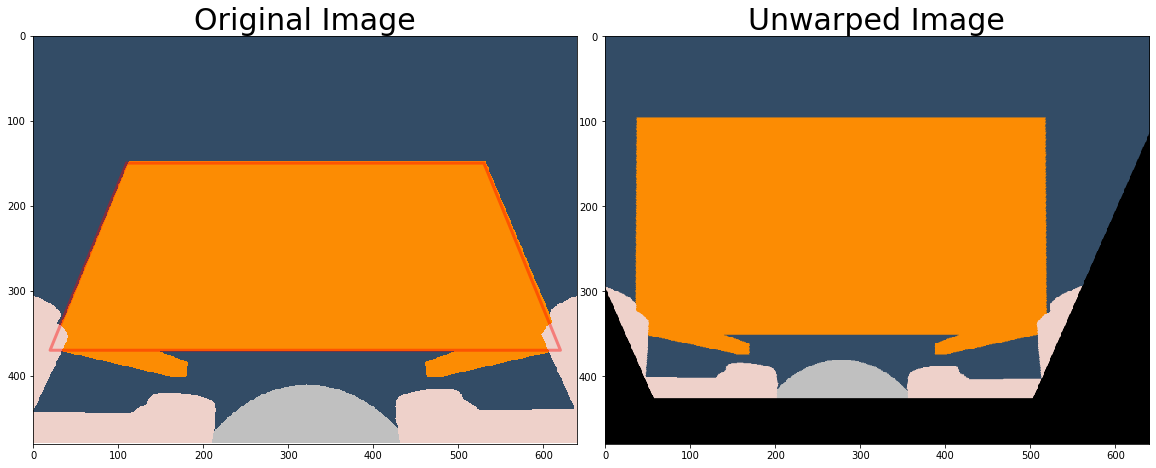

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def unwarp(img, src, dst, testing):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if testing:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        f.subplots_adjust(hspace=.2, wspace=.05)
        ax1.imshow(img)
        x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
        y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
        ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
        ax1.set_ylim([h, 0])
        ax1.set_xlim([0, w])
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(cv2.flip(warped, 1))
        ax2.set_title('Unwarped Image', fontsize=30)
        plt.show()
    else:
        return warped, M


im = rgb

w, h = im.shape[0], im.shape[1]
# We will first manually select the source points 
# we will select the destination point which will map the source points in
# original image to destination points in unwarped image
# src = np.float32([(20,     1),
#                   (540,  130),
#                   (20,    520),
#                   (570,  450)])

src = np.float32([(110,     150),
                  (530,  150),
                  (20,    370),
                  (620,  370)])

dst = np.float32([(120, 100),
                  (600, 100),
                  (120, 350),
                  (600, 350)])

unwarp(im, src, dst, True)

cv2.imshow("so", im)